<a href="https://colab.research.google.com/github/JaysonSuarez/IA/blob/main/ChatBot_Psicologo_RoBERTa_%2B_GENERATIVE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoBERTa con InterTASS
Debe descargar el Dataset del siguiente enlace: http://tass.sepln.org/2020/?page_id=74. El archivo .zip llamado: Task 1 - train and dev sets.

Y para correr en colab, debe usarse la version que usa GPU para que pueda funcionar.

## Paso 1: Instalación de librerías necesarias

In [ ]:
!pip install transformers scikit-learn pandas -q

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3


transformers: Proporciona acceso a modelos pre-entrenados como RoBERTa, utilizados para el procesamiento del lenguaje natural.
scikit-learn: Ofrece herramientas para el aprendizaje automático, incluyendo la codificación de etiquetas.
pandas: Permite la manipulación y análisis de datos con estructuras de datos como DataFrames.
--upgrade transformers: actualiza la librería transformers para que tengas la versión mas nueva

## Paso 2: Carga del dataset InterTASS

In [ ]:
import zipfile, glob, pandas as pd

zip_path = '/content/Task1-train-dev.zip'
extract_dir = 'intertass'

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)

def load_split(split):
    files = glob.glob(f"{extract_dir}/{split}/*.tsv")
    dfs = []
    for path in files:
        country = path.split('/')[-1].split('.')[0]
        df = pd.read_csv(path, sep='\t', header=None, names=['id','text','label'])
        df['country'] = country
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_train = load_split('train')
df_dev   = load_split('dev')

print(f"Train: {df_train.shape[0]} muestras")
print(f"Dev:   {df_dev.shape[0]} muestras")

Train: 4802 muestras
Dev:   2443 muestras


Carga el conjunto de datos InterTASS, que contiene texto etiquetado con emociones.

Descarga un archivo zip que contiene los datos de entrenamiento y desarrollo (train/dev).
Extrae los archivos del zip.
Lee los archivos TSV (texto separado por tabulaciones) y los combina en un DataFrame de pandas.
El resultado son dos DataFrames: df_train para entrenamiento y df_dev para desarrollo.

## Paso 3: Exploración de datos

In [ ]:
print(df_train.head())
print(df_train['label'].value_counts())

                   id                                               text  \
0  775087224857567232  Lo que mas amo de mi escritorio es que hay una...   
1  778485882647089152  Ese momento en el que no puedes dormir y no sa...   
2  774619666505400322  @Fiorela_Gue aw ! recién veo esto, sorrry ! tu...   
3  802359837308887040                @CJSuasnabar soy el perro asesinado   
4  812398630137012224          @DavidJeffer06 Ay! Esas medias tan lindas   

  label country  
0     P      pe  
1   NEU      pe  
2   NEU      pe  
3     N      pe  
4     P      pe  
label
N      1885
NEU    1523
P      1394
Name: count, dtype: int64


df_train.head(): Muestra las primeras filas del DataFrame de entrenamiento para ver su estructura y contenido.
df_train['label'].value_counts(): Cuenta la frecuencia de cada etiqueta de emoción en el conjunto de datos, lo que ayuda a comprender la distribución de las clases.

## Paso 4: Preprocesamiento de texto y etiquetas

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['label_enc'] = le.fit_transform(df_train['label'])
df_dev['label_enc']   = le.transform(df_dev['label'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'N': np.int64(0), 'NEU': np.int64(1), 'P': np.int64(2)}


Prepara los datos para ser utilizados por el modelo de aprendizaje automático.

LabelEncoder: Convierte las etiquetas de texto (como "joy", "sadness") a valores numéricos (0, 1, 2, etc.). Esto es necesario porque muchos modelos de aprendizaje automático trabajan con datos numéricos.

## Paso 5: Tokenización con RoBERTa

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('BSC-TeMU/roberta-base-bne')
def tokenize(df):
    return tokenizer(
        df['text'].tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt'
    )
train_enc = tokenize(df_train)
dev_enc   = tokenize(df_dev)
print(train_enc['input_ids'].shape, dev_enc['input_ids'].shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

torch.Size([4802, 128]) torch.Size([2443, 128])


Convierte el texto en una secuencia de tokens (unidades básicas de significado) que el modelo RoBERTa pueda entender.

AutoTokenizer: Carga un tokenizador pre-entrenado para RoBERTa.
tokenize(): Aplica el tokenizador al texto de los DataFrames, convirtiéndolo en secuencias numéricas y añadiendo padding para que todas las secuencias tengan la misma longitud.

## Paso 6: Fine-Tuning del modelo RoBERTa

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import os
os.environ["WANDB_DISABLED"] = "true"

model = AutoModelForSequenceClassification.from_pretrained(
    'BSC-TeMU/roberta-base-bne', num_labels=len(le.classes_)
)
train_dataset = torch.utils.data.TensorDataset(
    train_enc['input_ids'], train_enc['attention_mask'], torch.tensor(df_train['label_enc'].values)
)
dev_dataset   = torch.utils.data.TensorDataset(
    dev_enc['input_ids'], dev_enc['attention_mask'],   torch.tensor(df_dev['label_enc'].values)
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    from sklearn.metrics import f1_score
    return {
        'accuracy': (preds == labels).mean(),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

class IntertassDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IntertassDataset(train_enc, df_train['label_enc'].values)
dev_dataset = IntertassDataset(dev_enc, df_dev['label_enc'].values)

training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-2c43e201e2cc>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.820300
1000,0.532500
1500,0.297300
2000,0.136400
2500,0.054200
3000,0.021900


<ipython-input-9-2c43e201e2cc>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-2c43e201e2cc>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-2c43e201e2cc>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-2c43e201e2cc>:31: UserWarning: To copy construct from a 

TrainOutput(global_step=3005, training_loss=0.3099130956136843, metrics={'train_runtime': 677.4322, 'train_samples_per_second': 35.443, 'train_steps_per_second': 4.436, 'total_flos': 1579338289912320.0, 'train_loss': 0.3099130956136843, 'epoch': 5.0})

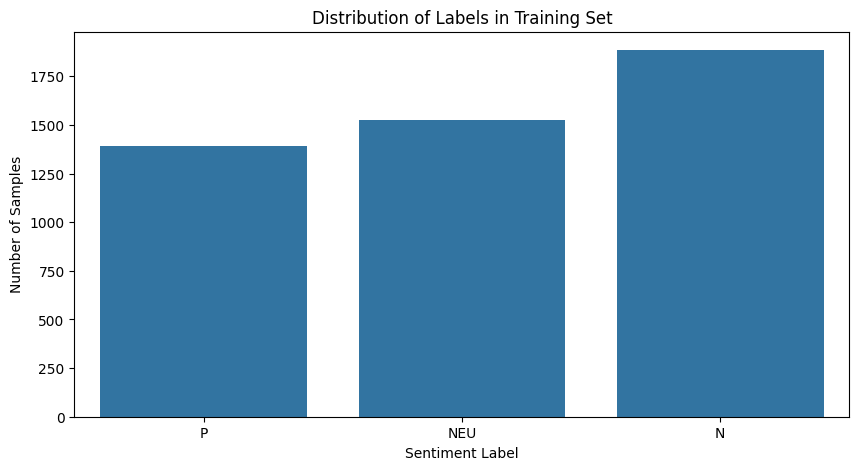

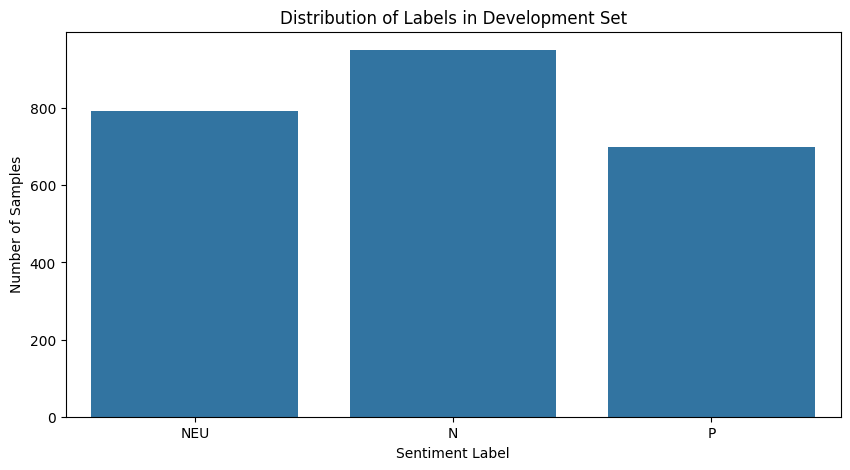

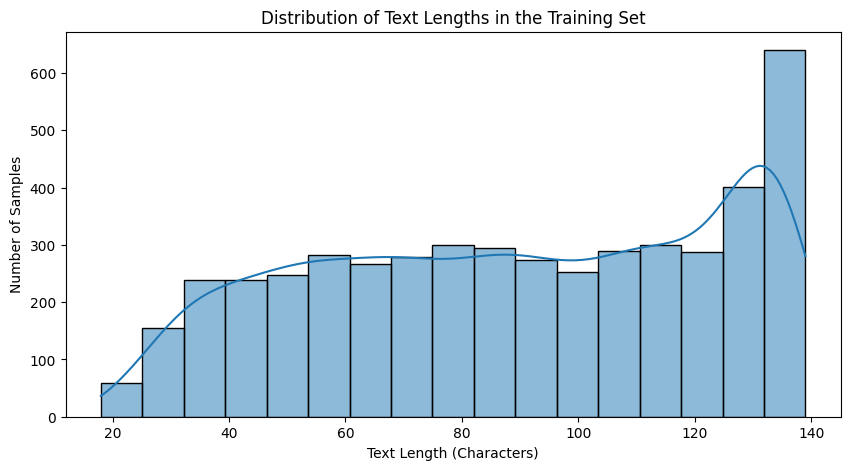

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Distribution of Labels in the Training Set
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df_train)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


# 2. Distribution of Labels in the Development Set
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df_dev)
plt.title('Distribution of Labels in Development Set')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


# 3. Text Length Analysis (optional - requires text length calculation)
# Calculate the length of each text in the training set
df_train['text_length'] = df_train['text'].apply(len)

# Create the plot
plt.figure(figsize=(10, 5))
sns.histplot(df_train['text_length'], kde=True)
plt.title('Distribution of Text Lengths in the Training Set')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Number of Samples')
plt.show()


Entrena el modelo RoBERTa para la tarea específica de análisis de sentimientos en el dataset InterTASS.

AutoModelForSequenceClassification: Carga un modelo RoBERTa pre-entrenado y lo adapta para la clasificación de secuencias (en este caso, clasificar emociones).
Trainer: Se encarga del proceso de entrenamiento, incluyendo la optimización de los parámetros del modelo.
compute_metrics: Define las métricas que se usarán para evaluar el rendimiento del modelo durante el entrenamiento, como la precisión y la puntuación F1.

## Paso 7: Evaluación y prueba de ejemplo

In [ ]:
def predict(text):
    enc = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    # Move the encoded input to the same device as the model
    enc = {k: v.to(model.device) for k, v in enc.items()}
    logits = model(**enc).logits
    return le.inverse_transform([logits.argmax().item()])[0]


while True:
  user_input = input("Introduce el texto para predecir el sentimiento: ")
  if user_input.lower() in ["basta", "stop", "salir", "exit", "fin", "end"]:
    break
  prediction = predict(user_input)
  print(f"El sentimiento predicho es: {prediction}")

Introduce el texto para predecir el sentimiento: fin


 Toma un texto como entrada, lo tokeniza, lo pasa por el modelo y devuelve la etiqueta de emoción predicha.

Ya que RoBERTa no es un LLM sino un Classifier, generamos un diccionario de posibles respuestas a las preguntas del user con el fin de:

**1. Clasificar la emoción**

**2. Analizar la emoción**

**3. "Generar" respuestas segun la emoción clasificada**

In [ ]:
import random

# Diccionario de respuestas según emoción
respuestas = {
    "tristeza": [
        "Lamento que te sientas así. Estoy aquí para escucharte.",
        "Es normal sentirse triste a veces. ¿Quieres hablar más al respecto?",
        "Tus emociones son válidas. No estás solo/a en esto.",
        "Estoy aquí para ti. Cuéntame más si lo deseas.",
        "La tristeza es una emoción humana. Permítete sentirla y expresarla."
    ],
    "ansiedad": [
        "Parece que estás experimentando ansiedad. Respirar profundamente puede ayudarte a calmarte.",
        "La ansiedad puede ser abrumadora. Estoy aquí para apoyarte.",
        "Recuerda que no estás solo/a. Hablar sobre lo que sientes puede aliviar la carga.",
        "¿Hay algo específico que te preocupa? Compartirlo puede ayudarte a procesarlo.",
        "La ansiedad es una respuesta natural al estrés. Juntos podemos encontrar formas de manejarla."
    ],
    "ira": [
        "Entiendo que te sientas enojado/a. Es importante reconocer esa emoción.",
        "La ira puede ser una señal de que algo no está bien. ¿Quieres hablar sobre ello?",
        "Tomarse un momento para respirar puede ayudar a manejar la ira.",
        "Estoy aquí para escucharte sin juzgar. Cuéntame qué te ha molestado.",
        "La ira es válida, pero encontrar formas saludables de expresarla es crucial."
    ],
    "miedo": [
        "El miedo es una emoción natural ante lo desconocido. Estoy aquí contigo.",
        "Hablar sobre lo que te asusta puede disminuir su poder. ¿Quieres compartirlo?",
        "Recuerda que eres fuerte y capaz de enfrentar tus temores.",
        "No estás solo/a en esto. Juntos podemos encontrar maneras de afrontarlo.",
        "Es valiente reconocer que sientes miedo. Estoy aquí para apoyarte."
    ],
    "alegría": [
        "¡Me alegra saber que te sientes bien! Comparte más sobre eso.",
        "Es maravilloso que experimentes alegría. Disfruta el momento.",
        "La alegría es contagiosa. Gracias por compartirla conmigo.",
        "Celebremos juntos tu felicidad. ¿Qué te ha hecho sentir así?",
        "Es genial escuchar noticias positivas. ¡Sigue compartiéndolas!"
    ],
    "sorpresa": [
        "¡Vaya, eso suena inesperado! ¿Cómo te sientes al respecto?",
        "Las sorpresas pueden ser emocionantes o desconcertantes. ¿Cuál fue tu reacción?",
        "Cuéntame más sobre lo que te sorprendió. Estoy interesado/a en saber.",
        "A veces, las sorpresas nos sacan de la rutina. ¿Fue una sorpresa agradable?",
        "Es interesante cómo ocurren cosas inesperadas. ¿Cómo lo estás manejando?"
    ],
    "desagrado": [
        "Entiendo que algo te ha causado desagrado. ¿Quieres hablar sobre ello?",
        "Es importante reconocer lo que no nos agrada. Estoy aquí para escucharte.",
        "Compartir lo que te molesta puede ayudarte a procesarlo.",
        "Todos experimentamos desagrado en algún momento. No estás solo/a.",
        "Hablar sobre lo que te incomoda puede ser liberador. ¿Te gustaría compartirlo?"
    ],
    "confianza": [
        "Es genial que te sientas confiado/a. Esa es una emoción poderosa.",
        "La confianza en uno mismo es clave para el bienestar. ¡Sigue así!",
        "Me alegra saber que te sientes seguro/a. ¿Qué ha contribuido a eso?",
        "La confianza puede abrir muchas puertas. ¿Hay algo que te gustaría compartir?",
        "Es inspirador ver tu confianza. ¿Qué te ha llevado a sentirte así?"
    ]
}

# Función para obtener una respuesta empática
def obtener_respuesta_emocional(emocion):
    return random.choice(respuestas.get(emocion, ["Estoy aquí para ti. Cuéntame más."]))


In [ ]:
polarity_to_possible_emotions = {
    "p": ["alegría","sorpresa"],       # Positive could relate to joy or surprise
    "n": ["tristeza", "miedo", "ansiedad", "ira", "desagrado", "frustrado"], # Negative could relate to several negative emotions
    "neu": ["confianza"]    # Neutral is harder to map; 'confianza' might fit some neutral contexts
    # You could add 'none': [] or similar if your dataset includes 'NONE'
}

# Permitir al usuario ingresar texto y obtener una respuesta basada en la polaridad detectada
while True:
  user_input = input("¿Cómo te sientes hoy? (escribe 'salir' para terminar): ")
  if user_input.lower() in ["salir", "terminar", "adiós"]:
    print("¡Hasta luego!")
    break
  if user_input:
    try:
      # Usar la función predict para obtener la POLARITY (P, N, NEU)
      predicted_polarity = predict(user_input)
      print(f"La polaridad predicha es: {predicted_polarity.capitalize()}")

      # Convert the predicted polarity to lowercase
      predicted_polarity_lower = predicted_polarity.lower()

      # Get the list of possible emotions for this polarity
      possible_emotions = polarity_to_possible_emotions.get(predicted_polarity_lower, []) # Default to empty list if polarity not found

      respuesta = "Entiendo. Estoy aquí para escucharte si quieres compartir más." # Default response if no matching emotion found

      if possible_emotions:
          # Pick one emotion randomly from the list of possible emotions for this polarity
          # Ensure the chosen emotion is a key in the 'respuestas' dictionary before using it
          valid_possible_emotions = [emo for emo in possible_emotions if emo in respuestas]

          if valid_possible_emotions:
              chosen_emotion = random.choice(valid_possible_emotions)
              # Get a response for the chosen emotion using the original function
              respuesta = obtener_respuesta_emocional(chosen_emotion)
          # If possible_emotions list was not empty but none were valid keys in 'respuestas',
          # we keep the default response defined above.

      print(respuesta)

    except Exception as e:
      print(f"Ocurrió un error al procesar tu entrada: {e}")
      # Print the traceback to help diagnose the error if needed
      import traceback
      traceback.print_exc()
  else:
    print("Por favor, ingresa algo sobre cómo te sientes.")

¿Cómo te sientes hoy? (escribe 'salir' para terminar): feliz
La polaridad predicha es: Neu
Es genial que te sientas confiado/a. Esa es una emoción poderosa.
¿Cómo te sientes hoy? (escribe 'salir' para terminar): salir
¡Hasta luego!


In [ ]:
!pip install cohere -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.4 MB/s eta 0:00:00


In [ ]:
import cohere
import random # Ensure random is imported if needed for the second loop (which it is for random.choice)
import traceback # Ensure traceback is imported for error handling


co = cohere.ClientV2('uGJ50Z2ilig2S60S5GbsIcIEwp1FdzosdkXkDsm8')

print("""-Recuerda que este chatbot es solo una herramienta de apoyo y no un sustituto de la ayuda profesional.
Las respuestas que se generen son con fines de mejora y no deben ser consideradas como un diagnóstico o tratamiento profesional.-""")


# Function to generate text using Cohere based on the detected emotion
def generate_cohere_response(emotion, user_text):
    prompt = f"El usuario expresó un sentimiento de {emotion} con el texto: \"{user_text}\". Genera una respuesta empática y comprensiva en español basada en este sentimiento."

    try:
        response = co.chat(
             model='command-a-03-2025',
             messages=[
                 {'role': 'system', 'content': f'Eres un chat únicamente entrenado para dar respuestas de ayuda psicológica, ninguna otra. Solo debes dar respuestas mejorativas, y no debes dar diagnósticos o tratamientos, ya que no eres un profesional. Responde de forma empática y comprensiva al usuario que expresó un sentimiento de {emotion} con el texto: "{user_text}".'},
                 {'role': 'user', 'content': user_text}
             ]
         )
        # Extract the text content from the response message
        return response.message.content[0].text.strip()

    except Exception as e:
        print(f"Error generating Cohere response: {e}")
        return "No pude generar una respuesta en este momento."

# Modify the main loop to use Cohere for generation
while True:
  user_input = input("¿Cómo te sientes hoy? (escribe 'salir' para terminar): ")
  if user_input.lower() in ["salir", "terminar", "adiós"]:
    print("¡Hasta luego!")
    break
  if user_input:
    try:
      predicted_polarity = predict(user_input)
      print(f"La polaridad predicha es: {predicted_polarity.capitalize()}")

      # Convert the predicted polarity to lowercase
      predicted_polarity_lower = predicted_polarity.lower()

      # Get the list of possible emotions for this polarity
      possible_emotions = polarity_to_possible_emotions.get(predicted_polarity_lower, [])

      respuesta = "Entiendo. Estoy aquí para escucharte si quieres compartir más." # Default response

      if possible_emotions:
          # Pick one emotion randomly from the list of possible emotions for this polarity
          valid_possible_emotions = [emo for emo in possible_emotions if emo in respuestas]

          if valid_possible_emotions:
              chosen_emotion = random.choice(valid_possible_emotions)
              print(f"(El chatbot interpretará esto como {chosen_emotion})") # Optional: show the interpreted emotion
              # Use Cohere to generate a response based on the chosen emotion and user text
              respuesta = generate_cohere_response(chosen_emotion, user_input)
      print(respuesta)

    except Exception as e:
      print(f"Ocurrió un error al procesar tu entrada: {e}")
      traceback.print_exc()
  else:
    print("Por favor, ingresa algo sobre cómo te sientes.")

-Recuerda que este chatbot es solo una herramienta de apoyo y no un sustituto de la ayuda profesional.
Las respuestas que se generen son con fines de mejora y no deben ser consideradas como un diagnóstico o tratamiento profesional.-
¿Cómo te sientes hoy? (escribe 'salir' para terminar): frustrado
La polaridad predicha es: Neu
(El chatbot interpretará esto como confianza)
Entiendo que te sientas frustrado. La frustración es una emoción muy común cuando las cosas no salen como esperamos o cuando nos enfrentamos a obstáculos que parecen insuperables. Es importante reconocer y validar esa emoción, porque es una señal de que algo en tu vida necesita atención.

Recuerda que la frustración no tiene por qué ser permanente. Aquí tienes algunas sugerencias que podrían ayudarte a manejarla:

1. **Identifica la fuente**: Trata de entender qué es lo que te está causando frustración. ¿Es una situación específica, una persona, o quizás una expectativa que no se ha cumplido?

2. **Expresa tus sentimie

# Este código ya utiliza una forma Prompt Chaining
El segundo bucle while utiliza la polaridad_prevista del modelo RoBERTa
(que está entrenado en el conjunto de datos TASS) para determinar un conjunto potencial de emociones. A continuación, utiliza una emoción elegida al azar de ese conjunto, junto con la entrada original del usuario, como parte de la solicitud de la API Cohere para generar una respuesta más matizada y contextualmente relevante.

# El código actual ya demuestra una cadena simple:
Entrada del Usuario -> Predicción RoBERTa (Polaridad) -> Asignar Polaridad a Posibles Emociones -> Elegir Emoción -> Mensaje Cohere -> Respuesta Cohere.
